In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
import os
from urllib.request import urlretrieve

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [3]:
# Check if CUDA is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [4]:
# Download the water demand dataset
year_1 = "https://surfdrive.surf.nl/files/index.php/s/hCXnLcb9zlYQHQd/download"
year_2 = "https://surfdrive.surf.nl/files/index.php/s/daXOMuxonOQL1oy/download"

data_folder = "data"
water_demand_file1 = os.path.join(data_folder, "water_demand_Y1.txt")
water_demand_file2 = os.path.join(data_folder, "water_demand_Y2.txt")

if not os.path.isfile(water_demand_file1):
    print("Downloading dataset...")
    os.makedirs("data", exist_ok=True)
    urlretrieve(year_1, water_demand_file1)
    urlretrieve(year_2, water_demand_file2)

In [5]:
# Correct file paths using raw string or double backslashes and correct file extension if they are indeed .txt files
r1 = r"C:\Users\yanzh\Desktop\Deep learning\water_demand_Y1.txt"
r2 = r"C:\Users\yanzh\Desktop\Deep learning\water_demand_Y2.txt"

# Load the data
df_year1 = pd.read_csv(r1, header=None, sep=r"\s+")
df_year2 = pd.read_csv(r2, header=None, sep=r"\s+")

# Concatenate the dataframes
df = pd.concat([df_year1, df_year2], axis=0).reset_index(drop=True)

# Display the first few rows of the dataframe
df.head()


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,699.9350,740.6850,714.9900,684.2525,597.7575,519.2425,510.1450,614.8825,795.5500,1006.1300,...,1026.0875,918.0225,906.0375,902.1875,922.1850,950.3275,966.3725,877.0875,791.2575,744.4600
1,650.4700,593.2275,539.6425,520.6075,511.2000,500.0075,617.5375,837.5200,987.4875,1081.5075,...,981.8050,908.3025,895.2125,894.2750,976.5050,1016.4225,1057.3275,961.8975,823.3100,775.7425
2,689.5650,610.3225,578.1475,541.6100,521.8300,514.6875,624.4775,838.6775,1012.2075,1105.9875,...,1023.3050,917.2225,905.3750,943.5700,984.5625,1051.1925,1063.4275,953.9950,823.5075,754.7550
3,713.5525,620.6775,569.6550,551.5575,526.7850,518.5625,563.0475,748.1525,965.0550,1149.5875,...,1065.4375,996.6850,988.6625,989.1775,1034.6575,1056.6000,1006.7700,902.1275,804.0650,788.1050
4,723.4175,633.9325,575.2450,545.4650,526.8325,498.9925,523.3400,645.5475,881.3875,1129.3075,...,1070.7375,970.1500,942.8125,933.8925,963.5175,983.4775,988.2550,875.5950,793.1400,761.0325


Text(0.5, 1.0, 'Water consumption for day #499')

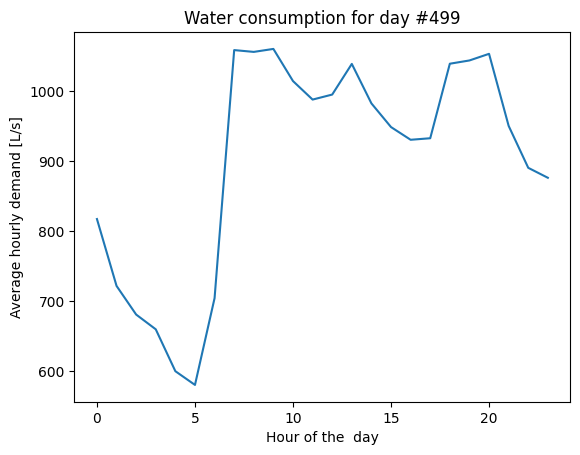

In [6]:
# plot random day
day_ix = np.random.randint(len(df))
ax = df.loc[day_ix].plot()
ax.set_xlabel('Hour of the  day')
ax.set_ylabel('Average hourly demand [L/s]')
ax.set_title(f'Water consumption for day #{day_ix}')

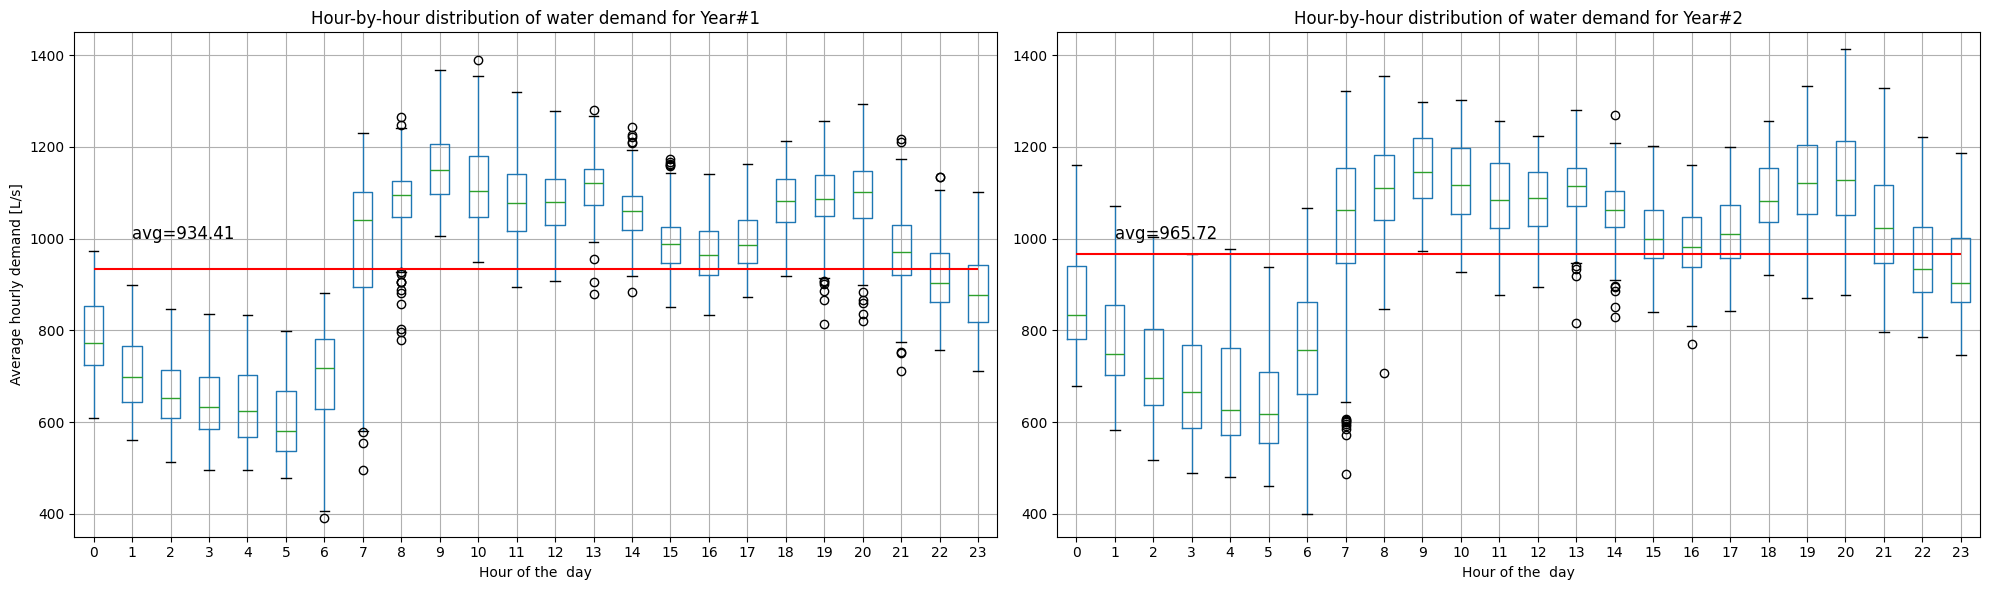

In [7]:
# plot hourly water demand distributions across all days

# year 1
f, axes = plt.subplots(1,2,figsize=(20,6))
df_year1.boxplot(ax=axes[0])
axes[0].set_xlabel('Hour of the  day');
axes[0].set_ylabel('Average hourly demand [L/s]');
axes[0].set_title('Hour-by-hour distribution of water demand for Year#1');
axes[0].set_ylim([350,1450])

avg_year1 = df_year1.values.reshape(-1).mean()
axes[0].hlines(avg_year1,1,24, colors='r')
axes[0].text(2, 1000, f'avg={avg_year1:.2f}', fontsize=12)

# year 2
df_year2.boxplot(ax=axes[1])
axes[1].set_xlabel('Hour of the  day');
# axes[1].set_ylabel('Average hourly demand [L/s]');
axes[1].set_title('Hour-by-hour distribution of water demand for Year#2');
axes[1].set_ylim([350,1450])

avg_year2 = df_year2.values.reshape(-1).mean()
axes[1].hlines(avg_year2,1,24, colors='r')
axes[1].text(2, 1000, f'avg={avg_year2:.2f}', fontsize=12)

f.tight_layout()

In [8]:
def create_sequences(series,T=168,H=24):
    # This function creates a dataset of input/output sequences from a time series.
    # The input sequence is T steps long, from time t to time t+T (excluded).
    # The output sequence is H steps long, from time t+T to time t+T+H (excluded).
    X = []
    Y = []
    for t in range(len(series)-T-H):
        x = series[t:t+T]
        X.append(x)
        y = series[t+T:t+T+H]
        Y.append(y)
    X = np.array(X)
    Y = np.array(Y)
    return X,Y

def scale_sequences(X,scaler=None,scaler_type='standard'):
    # Uses a standard scaler to transform sequences. The scaler is created if no scaler is passed as argument.
    Xshape=X.shape
    if scaler:
        X = scaler.transform(X.reshape(-1,1)).reshape(Xshape)
        return X
    else:
        if scaler_type == 'standard':
            scaler = StandardScaler()
        elif scaler_type == 'minmax':
            scaler = MinMaxScaler()
        else:
            raise Exception("Type of scikit-learn scaler not supported. Choose 'standard' or 'minmax.")
        X = scaler.fit_transform(X.reshape(-1,1)).reshape(Xshape)
        return X, scaler

In [9]:
df.values.reshape(-1)

array([699.935 , 740.685 , 714.99  , ..., 819.8325, 785.08  , 763.195 ])

In [10]:
T = 168     # number of time steps to use for prediction (168 hours = 1 week)
H = 1       # number of time steps to predict (1 hour)
X, Y = create_sequences(df.values.reshape(-1),T=T,H=H)
print(X.shape)
print(Y.shape)

(17351, 168)
(17351, 1)


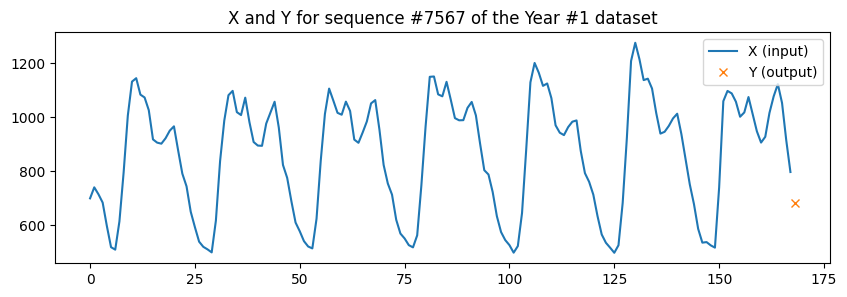

In [11]:
random_ix = np.random.choice(X.shape[0])
f, ax = plt.subplots(1,figsize=(10,3))
ax.plot(np.arange(T),X[0], label='X (input)')
ax.plot(np.arange(T,T+H),Y[0], 'x', label = 'Y (output)')
ax.set_title(f'X and Y for sequence #{random_ix} of the Year #1 dataset');
ax.legend();

In [12]:
# We keep track of indexes of train and validation.
X_tra, X_tst, Y_tra, Y_tst, ix_tra, ix_tst = train_test_split(
    X, Y, np.arange(X.shape[0]), test_size=0.30, shuffle=True, random_state=42)

# Split the existing test dataset into validation and test sets (50/50 split)
X_val, X_tst, Y_val, Y_tst, ix_val, ix_tst = train_test_split(
    X_tst, Y_tst, ix_tst, test_size=0.5, shuffle=True, random_state=42)


print(f"X_tra.shape: {X_tra.shape}, Y_tra.shape: {Y_tra.shape}")
print(f"X_val.shape: {X_val.shape}, Y_val.shape: {Y_val.shape}")
print(f"X_tst.shape: {X_tst.shape}, Y_tst.shape: {Y_tst.shape}")

X_tra.shape: (12145, 168), Y_tra.shape: (12145, 1)
X_val.shape: (2603, 168), Y_val.shape: (2603, 1)
X_tst.shape: (2603, 168), Y_tst.shape: (2603, 1)


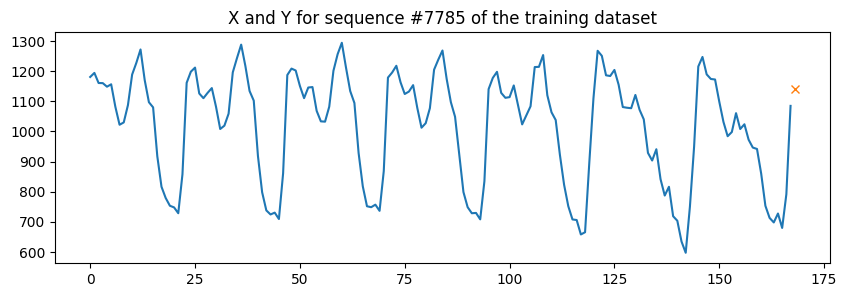

In [13]:
random_ix = np.random.choice(X_tra.shape[0])
f, ax = plt.subplots(1,figsize=(10,3))
ax.plot(np.arange(T),X_tra[random_ix], label='Xtra')
ax.plot(np.arange(T,T+H),Y_tra[random_ix], 'x', label = 'Ytra')
ax.set_title(f'X and Y for sequence #{random_ix} of the training dataset');

In [14]:
# scale/normalize
X_tra, scaler = scale_sequences(X_tra, scaler_type='standard')
Y_tra = scale_sequences(Y_tra, scaler)
X_val = scale_sequences(X_val, scaler)
Y_val = scale_sequences(Y_val, scaler)
X_tst = scale_sequences(X_tst, scaler)
Y_tst = scale_sequences(Y_tst, scaler)

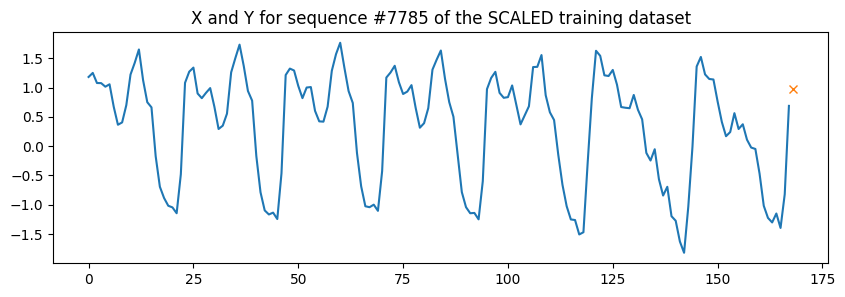

In [15]:
f, ax = plt.subplots(1,figsize=(10,3))
ax.plot(np.arange(T),X_tra[random_ix], label='Xtra')
ax.plot(np.arange(T,T+H),Y_tra[random_ix], 'x', label = 'Y (output)')
ax.set_title(f'X and Y for sequence #{random_ix} of the SCALED training dataset');

In [16]:
class MLP(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(MLP, self).__init__()
        # Define the layers of the network
        self.fc1 = nn.Linear(T, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Define the forward pass
        x = F.tanh(self.fc1(x))  # Activation function (ReLU) after first layer
        x = F.tanh(self.fc2(x))  # Activation function (ReLU) after second layer
        x = self.fc3(x)          # Output layer
        return x

In [17]:
class SimpleRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        # RNN layer
        self.rnn = nn.RNN(input_size=1, hidden_size=hidden_size, batch_first=True)

        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Reshape input to have feature dimension of 1
        x = x.unsqueeze(-1)   # Assuming input x has shape (batch, sequence)

        # RNN layer
        x, hn = self.rnn(x)   # We do not need the hidden states hn

        # Select the output of the last time step
        x = x[:, -1, :]

        # Output layer
        x = self.fc(x)

        return x

In [18]:
class SimpleRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        # RNN layer
        self.rnn = nn.RNN(input_size=1, hidden_size=hidden_size, batch_first=True)

        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Reshape input to have feature dimension of 1
        x = x.unsqueeze(-1)   # Assuming input x has shape (batch, sequence)

        # RNN layer
        x, hn = self.rnn(x)   # We do not need the hidden states hn

        # Select the output of the last time step
        x = x[:, -1, :]

        # Output layer
        x = self.fc(x)

        return x

In [19]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0

    with torch.no_grad():  # No need to track gradients during evaluation
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    return avg_test_loss

def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, save_path):
    best_val_loss = float("inf")  # Track the best validation loss
    train_losses = []
    val_losses = []

    start_time = time.time()  # Start training time

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        total_train_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation Phase
        avg_val_loss = evaluate_model(model, val_loader, criterion, device)
        val_losses.append(avg_val_loss)

        # Save Best Model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), save_path)

        if (epoch + 1) % 20 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}', f'Train Loss: {avg_train_loss:.4f}, '
                  f'Validation Loss: {avg_val_loss:.4f}', f'Best Validation Loss: {best_val_loss:.4f}')
    train_time = time.time() - start_time
    print("Training complete.")
    return train_losses, val_losses, best_val_loss, train_time

In [20]:
train_dataset = TensorDataset(torch.tensor(X_tra, dtype=torch.float32), torch.tensor(Y_tra, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(Y_val, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_tst, dtype=torch.float32), torch.tensor(Y_tst, dtype=torch.float32 ))

In [21]:
batch_size = 256      # You can modify this based on your requirements

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [22]:
num_epochs = 200
lr = 0.0005

In [23]:
model_MLP = MLP(256, H).to(device)

In [24]:
# Loss function
criterion = nn.MSELoss()  # Or another appropriate loss function

optimizer = optim.AdamW(model_MLP.parameters(), lr=lr)
save_path_MLP = './models/MLP_model.pth'

if not os.path.exists('./models'):
    os.makedirs('./models')

In [25]:
train_losses_MLP, val_losses_MLP, best_val_loss_MLP, time_MLP = train_and_validate(model_MLP, train_loader, val_loader, criterion, optimizer, num_epochs, device, save_path_MLP)

Epoch 20/200 Train Loss: 0.0211, Validation Loss: 0.0248 Best Validation Loss: 0.0242
Epoch 40/200 Train Loss: 0.0181, Validation Loss: 0.0226 Best Validation Loss: 0.0219
Epoch 60/200 Train Loss: 0.0161, Validation Loss: 0.0204 Best Validation Loss: 0.0204
Epoch 80/200 Train Loss: 0.0158, Validation Loss: 0.0218 Best Validation Loss: 0.0204
Epoch 100/200 Train Loss: 0.0143, Validation Loss: 0.0208 Best Validation Loss: 0.0199
Epoch 120/200 Train Loss: 0.0137, Validation Loss: 0.0210 Best Validation Loss: 0.0199
Epoch 140/200 Train Loss: 0.0126, Validation Loss: 0.0198 Best Validation Loss: 0.0196
Epoch 160/200 Train Loss: 0.0120, Validation Loss: 0.0203 Best Validation Loss: 0.0196
Epoch 180/200 Train Loss: 0.0117, Validation Loss: 0.0188 Best Validation Loss: 0.0188
Epoch 200/200 Train Loss: 0.0111, Validation Loss: 0.0194 Best Validation Loss: 0.0188
Training complete.


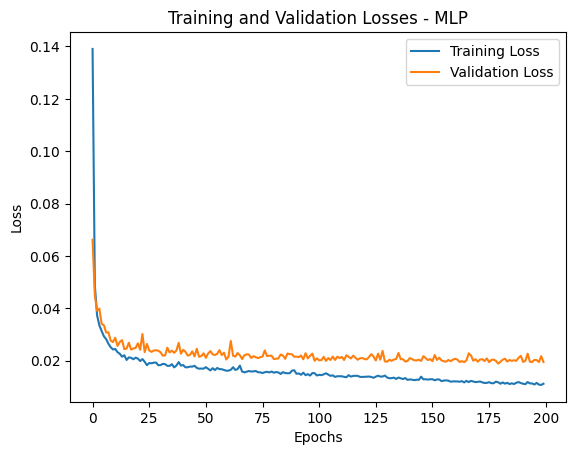

In [26]:
plt.plot(train_losses_MLP, label='Training Loss')
plt.plot(val_losses_MLP, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses - MLP')
plt.legend()
plt.show()

In [27]:
model_RNN = SimpleRNN(128, H).to(device)

In [28]:
# Loss function
criterion = nn.MSELoss()  # Or another appropriate loss function

optimizer = optim.AdamW(model_RNN.parameters(), lr=lr)
save_path_RNN = './models/RNN_model.pth'

In [29]:
train_losses_RNN, val_losses_RNN, best_val_loss_RNN, time_RNN = train_and_validate(model_RNN, train_loader, val_loader, criterion, optimizer, num_epochs, device, save_path_RNN)

Epoch 20/200 Train Loss: 0.0498, Validation Loss: 0.0578 Best Validation Loss: 0.0528
Epoch 40/200 Train Loss: 0.0666, Validation Loss: 0.0732 Best Validation Loss: 0.0395
Epoch 60/200 Train Loss: 0.0536, Validation Loss: 0.0526 Best Validation Loss: 0.0395
Epoch 80/200 Train Loss: 0.0468, Validation Loss: 0.0524 Best Validation Loss: 0.0395
Epoch 100/200 Train Loss: 0.0456, Validation Loss: 0.0469 Best Validation Loss: 0.0395
Epoch 120/200 Train Loss: 0.0409, Validation Loss: 0.0488 Best Validation Loss: 0.0395
Epoch 140/200 Train Loss: 0.0445, Validation Loss: 0.0581 Best Validation Loss: 0.0395
Epoch 160/200 Train Loss: 0.0393, Validation Loss: 0.0417 Best Validation Loss: 0.0395
Epoch 180/200 Train Loss: 0.0362, Validation Loss: 0.0432 Best Validation Loss: 0.0379
Epoch 200/200 Train Loss: 0.0359, Validation Loss: 0.0380 Best Validation Loss: 0.0373
Training complete.


sfss

In [ ]:
# Load the best model
model_RNN.load_state_dict(torch.load(save_path_RNN))   

In [ ]:
plt.plot(train_losses_RNN, label='Training Loss')
plt.plot(val_losses_RNN, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses - RNN')
plt.legend()
plt.show()